Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

In [ ]:
 !pip install -q kaggle
 from google.colab import files
 files.upload() #Choose the kaggle.json file that you downloaded

 !mkdir ~/.kaggle #Make directory named kaggle 

Saving kaggle.json to kaggle.json


In [ ]:
!cp kaggle.json ~/.kaggle/ #Copy kaggle.json file there.

!chmod 600 ~/.kaggle/kaggle.json #Change the permissions of the file

**That's all ! You can check if everything's okay by running this command**

Using the code :
```
!kaggle datasets list
```



In [ ]:
!kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-30 11:37:00           8585  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5242  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1836  
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1211  
coloradokb/dandelionimages                                    Da


#To download and unzip the dataset in one go:
---

you can copy the required dataset URL suffix which is found after "kaggle.com/". Let's call it url_suffix here
OR just click the kabab menu beside the download button from the dataset page and click copy the API command.
Then run the below line to download it into the sample_data Colab folder:

`!kaggle datasets download *url_suffix* -p /content/sample_data/ --unzip`

In [ ]:
!kaggle datasets download -d nirbhay727452/distracteddriverdetection

 96% 181M/188M [00:01<00:00, 99.7MB/s]
100% 188M/188M [00:02<00:00, 97.4MB/s]


In [ ]:
!mkdir driver_actions

In [ ]:
!unzip distracteddriverdetection.zip -d driver_actions

Archive:  distracteddriverdetection.zip
  inflating: driver_actions/data/test/test/img_1.jpg  
  inflating: driver_actions/data/test/test/img_10.jpg  
  inflating: driver_actions/data/test/test/img_100.jpg  
  inflating: driver_actions/data/test/test/img_1000.jpg  
  inflating: driver_actions/data/test/test/img_1001.jpg  
  inflating: driver_actions/data/test/test/img_1002.jpg  
  inflating: driver_actions/data/test/test/img_1003.jpg  
  inflating: driver_actions/data/test/test/img_1004.jpg  
  inflating: driver_actions/data/test/test/img_1006.jpg  
  inflating: driver_actions/data/test/test/img_1007.jpg  
  inflating: driver_actions/data/test/test/img_1008.jpg  
  inflating: driver_actions/data/test/test/img_1009.jpg  
  inflating: driver_actions/data/test/test/img_101.jpg  
  inflating: driver_actions/data/test/test/img_1011.jpg  
  inflating: driver_actions/data/test/test/img_1013.jpg  
  inflating: driver_actions/data/test/test/img_1014.jpg  
  inflating: driver_actions/data/test/t

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np

import pandas as pd

use_cuda = torch.cuda.is_available()
if use_cuda:
  print("GPU available, all computation will be done on GPU")

GPU available, all computation will be done on GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random
import os
from shutil import copy


def build_dataset(dataset_dir = '/content/driver_actions/data/train'):
    """
    Split original dataset into train and test sets.
    """

    for subdir, dirs, files in os.walk(dataset_dir):
        file_paths = []
        folder_name = os.path.basename(subdir)

        for file in files:
            file_paths.append(os.path.join(subdir, file))

        if len(file_paths) > 0:
            file_paths.sort()  # make sure that the file_paths have a fixed order before shuffling
            random.seed(230)
            random.shuffle(file_paths)

            boundary = int(0.64 * len(file_paths))
            train = file_paths[:boundary]
            valid_test_boundary = int(0.8 * len(file_paths))
            valid = file_paths[boundary:valid_test_boundary]
            test = file_paths[valid_test_boundary:]

            # create folders
            if not os.path.exists(os.path.join('/content/dataset/train', folder_name)):
                os.makedirs(os.path.join('/content/dataset/train', folder_name))

            if not os.path.exists(os.path.join('/content/dataset/valid', folder_name)):
                os.makedirs(os.path.join('/content/dataset/valid', folder_name))

            if not os.path.exists(os.path.join('/content/dataset/test', folder_name)):
                os.makedirs(os.path.join('/content/dataset/test', folder_name))

            # copy images in created folders
            for path in train:
                copy(path, os.path.join('/content/dataset/train', folder_name))
            
            for path in train:
                copy(path, os.path.join('/content/dataset/valid', folder_name))

            for path in test:
                copy(path, os.path.join('/content/dataset/test', folder_name))

    print("Done building dataset")



In [ ]:
!rm -rf dataset

In [ ]:

build_dataset()

Done building dataset


#**DATA AUGMENTATION**
This is necessary in this project because we have a limited dataset and we need to create varients of the dataset to be able to generalize the model learning.


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
# valid_size = 0.2 #this gives a ratio of 64:16:20 for training,validation and testing respectively

normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        # transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        normalizer])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalizer])

data_dir = '/content/dataset/'
train_dataset = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
valid_dataset = datasets.ImageFolder(data_dir + 'valid', transform=test_transforms)
test_dataset = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

# num_train = len(train_dataset)
# indices = list(range(num_train))

# np.random.shuffle(indices)

# split = int(np.floor(valid_size * num_train))

# train_index, validation_index = indices[split:], indices[:split]

# train_sampler = SubsetRandomSampler(train_index)
# validation_sampler = SubsetRandomSampler(validation_index)

# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=num_workers)
# validationloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=validation_sampler, num_workers=num_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=num_workers, shuffle = True)
validationloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, num_workers=num_workers, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=num_workers, shuffle = True)




In [ ]:
loader = {'train':trainloader, 'valid':validationloader, 'test':testloader}

#**Use Transfer Learning To Train the Model**

In [ ]:
model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
# Only train the classifier parameters, feature parameters are frozen
for params in model.features.parameters():
  params.requires_grad = False

# Refactor the output layer to match with the desired numbers of output
in_feature = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features=in_feature, out_features= 10)

# Move model to GPU if available
if use_cuda:
  model = model.cuda()

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Set the loss function and the appropraite optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [ ]:
from datetime import datetime


train_losses, valid_losses = [], []
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  """train and return the trained model"""
  #initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
  now = datetime.now()
  current_time = now.strftime("%d/%m/%y %H:%M:%S")
  print("Start time = ", current_time)
  

  for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()
    for batch_index, (data, target) in enumerate(loaders['train']):
      #move dataset to GPU is available
      if use_cuda:
        data, target = data.cuda(), target.cuda()

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      train_loss= train_loss + ((1/(batch_index+1))*(loss.data - train_loss))
      loss.backward()
      optimizer.step()

    model.eval()
    for batch_index, (data, target) in enumerate(loaders['valid']):
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      valid_loss=valid_loss + ((1/(batch_index + 1)) * (loss.data - valid_loss))

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
      print('Validation loss has decreased FROM {:.6F} TO {:.6f}. Saving Model to {}'.format(valid_loss_min, valid_loss, save_path))
      torch.save(model.state_dict(), save_path)
      valid_loss_min = valid_loss

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
  now = datetime.now()
  current_time = now.strftime("%d/%m/%Y %H:%M:%S")
  print("End Time = ", current_time)
  return model

In [ ]:

def test(loaders, model, criterion, use_cuda):
  test_loss =0.0
  correct = 0.0
  total = 0.0

  model.eval()
  for batch_index, (data, target) in enumerate(loaders['test']):
    if use_cuda:
      data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss =  test_loss +((1/(batch_index+1))*(loss.data-test_loss))
    pred = output.data.max(1, keepdim=True)[1]

    correct+=np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
    total += data.size(0)

  print('Test Loss: {:.6f}\n'.format(test_loss))
 
  print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [ ]:
model = train(50, loader, model, optimizer, 
                      criterion, use_cuda, 'driver_action_model.pt')

Start time =  29/06/21 09:52:29
Epoch: 1 	Training Loss: 2.241304 	Validation Loss: 1.684835
Validation loss has decreased FROM INF TO 1.684835. Saving Model to driver_action_model.pt
Epoch: 2 	Training Loss: 1.934925 	Validation Loss: 1.097801
Validation loss has decreased FROM 1.684835 TO 1.097801. Saving Model to driver_action_model.pt
Epoch: 3 	Training Loss: 1.685559 	Validation Loss: 0.693098
Validation loss has decreased FROM 1.097801 TO 0.693098. Saving Model to driver_action_model.pt
Epoch: 4 	Training Loss: 1.532498 	Validation Loss: 0.560716
Validation loss has decreased FROM 0.693098 TO 0.560716. Saving Model to driver_action_model.pt
Epoch: 5 	Training Loss: 1.389019 	Validation Loss: 0.438718
Validation loss has decreased FROM 0.560716 TO 0.438718. Saving Model to driver_action_model.pt
Epoch: 6 	Training Loss: 1.288511 	Validation Loss: 0.316669
Validation loss has decreased FROM 0.438718 TO 0.316669. Saving Model to driver_action_model.pt
Epoch: 7 	Training Loss: 1.1402

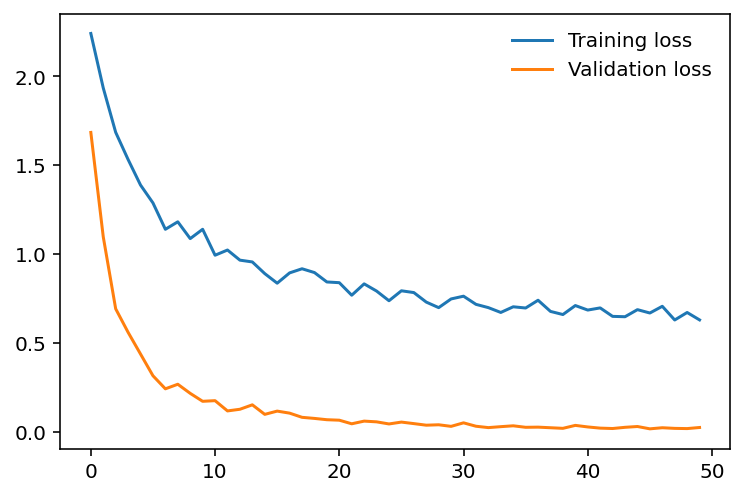

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
from shutil import copy
copy("/content/driver_action_model.pt", "/content/drive/My Drive/")

'/content/drive/My Drive/driver_action_model.pt'

In [ ]:
test(loader, model, criterion, use_cuda)

Test Loss: 0.126146


Test Accuracy: 96% (601/623)


In [ ]:
def test_class_understanding(loaders):
  data_dir = '/content/dataset'
  train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
  classes = [item.replace("_", " ") for item in train_data.classes]
  # track test loss
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  # iterate over test data
  for batch_idx, (data, target) in enumerate(loaders['test']):
      # move tensors to GPU if CUDA is available
      if use_cuda:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(10):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # average test loss
  test_loss = test_loss/len(loaders['test'].dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
test_class_understanding(loader)

Test Loss: 0.125701

Test Accuracy of    c0: 88% (16/18)
Test Accuracy of    c1: 100% (16/16)
Test Accuracy of    c2: 100% (16/16)
Test Accuracy of    c3: 100% (18/18)
Test Accuracy of    c4: 100% (19/19)
Test Accuracy of    c5: 100% (26/26)
Test Accuracy of    c6: 100% (24/24)
Test Accuracy of    c7: 100% (13/13)
Test Accuracy of    c8: 92% (24/26)
Test Accuracy of    c9: 91% (22/24)

Test Accuracy (Overall): 97% (194/200)


#**YOU CAN CONTINUE FROM HERE ANYTIME AFTER TRAINING**

In [ ]:
from shutil import copy
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
 
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
 
 
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
# import dataset_builder
 
from sklearn.metrics import accuracy_score
use_cuda = torch.cuda.is_available()

copy("/content/drive/My Drive/driver_action_model.pt","/content/" )

'/content/driver_action_model.pt'

In [ ]:
def get_model_structure():
  loaded_model = models.vgg16(pretrained=True)
  for params in loaded_model.features.parameters():
    params.requires_grad = False
 
  in_feature = loaded_model.classifier[6].in_features
  loaded_model.classifier[6] = nn.Linear(in_feature, 10)
  if use_cuda:
    loaded_model = loaded_model.cuda()
  loaded_model.load_state_dict(torch.load('driver_action_model.pt'))
  return loaded_model.eval()

In [ ]:
saved_model = get_model_structure()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
normalizer =  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Transforms for the training data and testing data
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
       normalizer
    ])

data_dir = '/content/dataset'
# train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
# class_names = [item.replace("_", " ") for item in train_data.classes]
class_names = ["focusing", "operating phone right", "answering phone right", 
               "operating phone left", "answering phone left","operating radio", 
               "drinking", "reaching behind", "making up",  "looking away"]


def predict_action(image):
    saved_model.eval()
    # load the image and return the predicted action
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    # transforms.CenterCrop(224),
    image_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize])
    # image = Image.open(img_path)
    # plt.imshow(image)
    # plt.show()
    image_tensor = image_transform(image)
    image_tensor.unsqueeze_(0)
    if use_cuda:
      image_tensor = image_tensor.cuda()
      # model_transfer = model_transfer.cuda()

    output = saved_model(image_tensor)
    # print(output)
    sm = nn.Softmax() #probability distribution
    sg= nn.Sigmoid() #probability certainity
    # probs = sm()
    # print(probs)
    probs = sg(output)
    # print(probs)
    certainity = torch.max(probs)
    print("Certaintity Level: {:.2f}%".format((certainity.cpu().detach().numpy() *100)))
    # top3_probs, top3_labels = torch.topk(probs, 3)
    # print("Top Three")
    # print(top3_probs)
    # print(top3_labels)
    a, pred_tensor = torch.max(output, 1)
    # print(pred_tensor)
   
    pred = np.squeeze(pred_tensor.numpy()) if not use_cuda else np.squeeze(pred_tensor.cpu().numpy())
    return class_names[pred]

print(class_names)

['focusing', 'operating phone right', 'answering phone right', 'operating phone left', 'answering phone left', 'operating radio', 'drinking', 'reaching behind', 'making up', 'looking away']


Certaintity Level: 72.45%
Hello Welcome to Driver Action Detector 



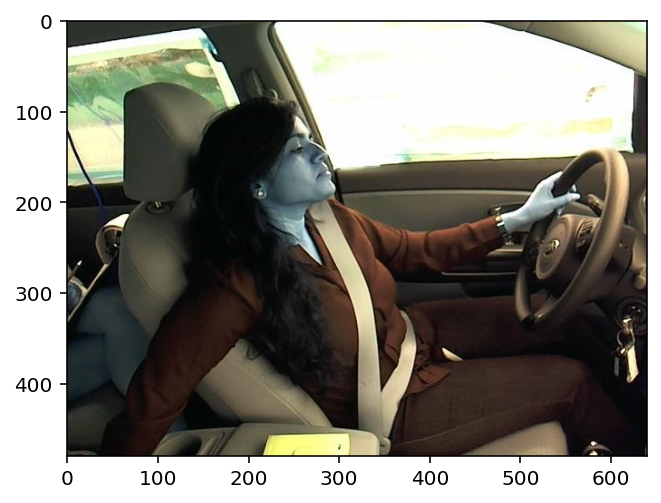

Identified to be: making up




In [ ]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

img_path = cv2.imread("/content/driver_actions/data/train/c7/img_233.jpg")
action = predict_action(img_path)
welcome_text = "Hello Welcome to Driver Action Detector "
output_text = "Identified to be: " + action
print("{}\n".format(welcome_text))
plt.imshow(img_path)#Image.open(annot_img))#img_path
plt.show()
print("{}\n=====================================================\n\n".format(output_text))